# Import packages

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Question 1: Choosing the right metrics when dealing with unbalanced data

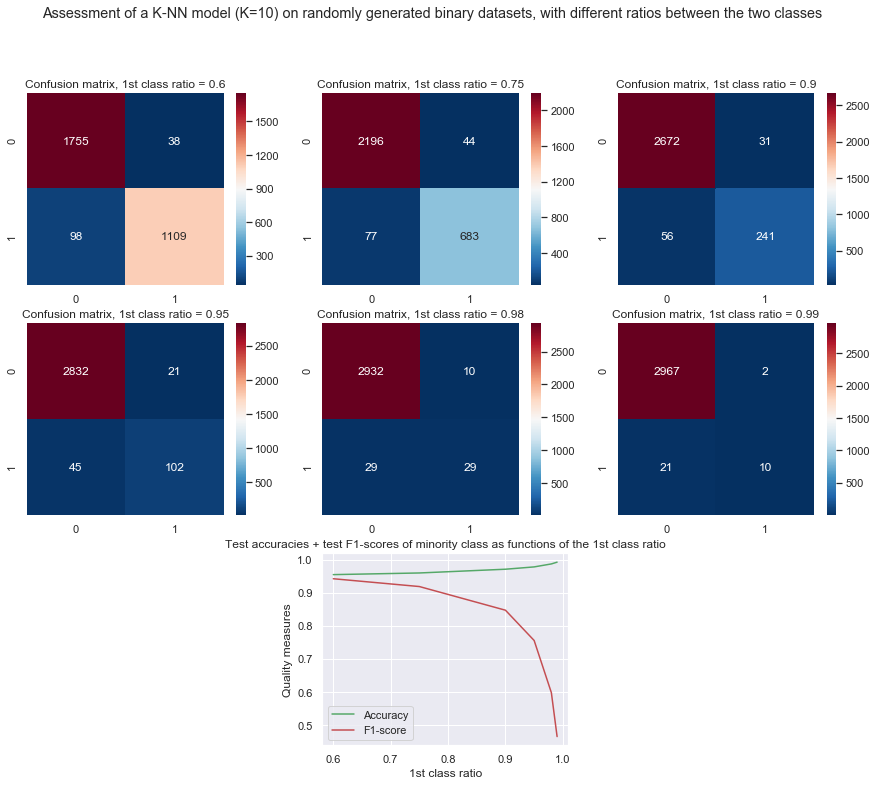

In [21]:
# Fix random seed for reproducibility:
seed = 666
# Set up seaborn (for heatmaps):
sns.set()

### Train and evaluate a K-NN with K=10 on randomly generated binary dataset, with different ratios between 
### the two classes. Use both accuracy and F1 score metrics, plus the confusion matrix:
ratios = [0.6, 0.75, 0.9, 0.95, 0.98, 0.99]
test_accuracies = []
test_f1_scores = []
test_confusion_matrices = []
for ratio in ratios:
    X, Y = make_classification(n_samples=10000, 
                               n_classes=2, 
                               n_features=2, 
                               n_redundant=0, 
                               n_repeated=0, 
                               weights=[ratio],
                               flip_y=0, 
                               random_state=seed)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, Y_train)
    Y_pred = neigh.predict(X_val)

    test_accuracies.append(accuracy_score(Y_val, Y_pred))
    test_f1_scores.append(f1_score(Y_val, Y_pred))
    test_confusion_matrices.append(confusion_matrix(Y_val, Y_pred))

for test_confusion_matrix, ratio, idx in zip(test_confusion_matrices, ratios, range(len(ratios))):
    plt.figure(1, figsize=(15, 12))
    plt.subplot(3, 3, idx+1)
    plt.title("Confusion matrix, 1st class ratio = " + str(ratio))
    sns.heatmap(data=test_confusion_matrix.round(2), annot=True, fmt='d', cmap=sns.color_palette("RdBu_r", 1000))
plt.figure(1)
plt.suptitle("Assessment of a K-NN model (K=10) on randomly generated binary datasets, with different ratios between the two classes")
plt.subplot(3, 3, 8)
plt.title("Test accuracies + test F1-scores of minority class as functions of the 1st class ratio")
plt.plot(ratios, test_accuracies, c='g')
plt.plot(ratios, test_f1_scores, c='r')
plt.legend(["Accuracy", "F1-score"], loc='best')
plt.xlabel('1st class ratio')
plt.ylabel('Quality measures')
plt.show()

# Question 2: Model selection with Kfold cross-validation for classification on unbalanced data

In [30]:
### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

### Select a model via Kfold cross-validation:
def KFold_model_selection(X, Y, models, num_folds, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    # Extract train and validation folds:
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X_train_val, Y_train_val, num_folds, seed)
    # For each hyper-parameter instance, do KFold cross validation:
    mean_val_MSEs = []
    for index in [0,1,2]:
        print("\nNow preprocessing Model", index)
        mean_val_MSE = perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds,index)
        print("Mean validation MSE:", mean_val_MSE)
        mean_val_MSEs.append(mean_val_MSE)
    # The hyper-parameter instance with the smallest mean validation MSE is our model of choice:
    best_instance_idx = mean_val_MSEs.index(max(mean_val_MSEs))
    best_hyper_model = models[best_instance_idx]
    print("\n\nBest Model:", best_hyper_model)
    # Train and evaluate the best instance on the whole dataset:
    best_model_test_MSE = assess_model(X_train_val, X_test, Y_train_val, Y_test,best_instance_idx)
    print("Test MSE:", best_model_test_MSE)

### KFold cross-validation of a model:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, model_idx):
    val_fold_MSEs = []
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    cmpt = 0
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_MSE = assess_model(X_train_fold, X_val_fold, Y_train_fold, Y_val_fold, model_idx)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation MSE:", val_fold_MSE)
        val_fold_MSEs.append(val_fold_MSE)
    # Compute the mean validation MSE between all the folds:
    mean_val_MSE = np.mean(val_fold_MSE)
    return mean_val_MSE

### Fit and evaluate a model:
def assess_model(X_train, X_test, Y_train, Y_test, model_idx):
    
    if model_idx==0:
        neigh = KNeighborsClassifier(n_neighbors=20)
        neigh.fit(X_train, Y_train)
        # Evaluate
        Y_pred = neigh.predict(X_test)
        test_performance = f1_score(Y_test, Y_pred)
    elif model_idx==1:
        clf = LogisticRegression()
        clf.fit(X_train, Y_train)
        # Evaluate
        Y_pred = clf.predict(X_test)
        test_performance = f1_score(Y_test, Y_pred)
    elif model_idx==2:
        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(X_train, Y_train)
        # Evaluate
        Y_pred = clf.predict(X_test)
        test_performance = f1_score(Y_test, Y_pred)
        
    return test_performance

In [31]:
### Model selection of a classification model on unbalanced data with KFold cross-validation:
# Load an unbalanced binary dataset:
with open('custom_unbalanced_dataset.pickle', 'rb') as unbalanced_dataset:
    X, Y = pickle.load(unbalanced_dataset)
    # Models to be cross-validated:
    models = {0: "K-NN, K=20",
              1: "Logistic regression",
              2: "Decision Tree"}
    # Select model with KFold cross-validation (use 10 folds):
    KFold_model_selection(X, Y, models, 10, seed)


Now preprocessing Model 0
Surrogate model 1/10 validation MSE: 0.8571428571428571
Surrogate model 2/10 validation MSE: 0.8356164383561644
Surrogate model 3/10 validation MSE: 0.8169014084507041
Surrogate model 4/10 validation MSE: 0.8299319727891157
Surrogate model 5/10 validation MSE: 0.8734177215189874
Surrogate model 6/10 validation MSE: 0.8695652173913043
Surrogate model 7/10 validation MSE: 0.888888888888889
Surrogate model 8/10 validation MSE: 0.8333333333333334
Surrogate model 9/10 validation MSE: 0.888888888888889
Surrogate model 10/10 validation MSE: 0.9064748201438848
Mean validation MSE: 0.9064748201438848

Now preprocessing Model 1
Surrogate model 1/10 validation MSE: 0.8688524590163935
Surrogate model 2/10 validation MSE: 0.8391608391608393
Surrogate model 3/10 validation MSE: 0.8226950354609929
Surrogate model 4/10 validation MSE: 0.8
Surrogate model 5/10 validation MSE: 0.8589743589743589
Surrogate model 6/10 validation MSE: 0.8571428571428571
Surrogate model 7/10 valid